In [14]:
import torch.nn as nn
class Net(nn.Module):
    def __init__(self, D_in, H1, H2, D_out):
 
        super(Net, self).__init__()
        self.linear1 = nn.Linear(D_in, H1) 
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, D_out)
  
    def forward(self, x):
    
        x = torch.sigmoid(self.linear1(x))
        x = torch.sigmoid(self.linear2(x))
        x = self.linear3(x)
        return x


In [15]:
import torch 
import xlrd
from sklearn.preprocessing import StandardScaler
import numpy as np

N, D_in, H1, H2, D_out = 100, 5, 15, 9, 3
model = Net(D_in, H1, H2, D_out)

model.load_state_dict(torch.load("C:/Users/Gabriel/Documents/Python/ANN2.pt"))
model.eval()
book = xlrd.open_workbook('dataset for standardisation.xlsx')
sheet = book.sheet_by_name('Sheet1')
data4 = [[sheet.cell_value(r, c)
         for c in range(1,6)] for r in range(2,74)]
data5 = [[sheet.cell_value(r, c)
         for c in range(6,9)] for r in range(2,74)]
scaler = StandardScaler()
scaler2 = StandardScaler()


In [16]:

book = xlrd.open_workbook('Experimental Data edited.xlsx')
sheet = book.sheet_by_name('Sheet2')
data = [[sheet.cell_value(r, c)
         for c in range(1,6)] for r in range(98,110)]
data2 = [[sheet.cell_value(r, c)
         for c in range(1,4)] for r in range(98,110)]
data3 = [[sheet.cell_value(r, c)
         for c in range(1,4)] for r in range(99,111)]
scaler = StandardScaler(with_mean=True, with_std=True)


scaler.fit(data4)
scaler2.fit(data5)
n = np.array(data)
q= torch.tensor(n[:,:])
standardised_data = scaler.transform(data)

standardised_data2 = standardised_data[:, 0:3] 



x = torch.tensor(standardised_data)
z = torch.tensor(standardised_data2)
v = torch.tensor(data3)

with torch.no_grad():
        dx_dt_pred = model(x.float())
     
        predictions= np.array(dx_dt_pred)
        descaled_predictions = scaler2.inverse_transform(predictions)
        usable_predictions = torch.tensor(descaled_predictions)
        q[:, 0:3]  = (usable_predictions*12) + q[:, 0:3]
        print(q[:, 0:3])
        np_x = np.array(q[:, 0:3])
    
 
        results=torch.tensor(np_x)
predictions_final=torch.tensor(results)  
print(results)
x_plot=predictions_final.view(12, 3)
print(x_plot) 

print(v)




tensor([[4.1093e-01, 2.5413e+03, 7.3692e-01],
        [6.2801e-01, 2.8373e+03, 1.3410e+00],
        [8.7443e-01, 2.4264e+03, 1.7682e+00],
        [1.1206e+00, 2.3999e+03, 2.1920e+00],
        [1.3577e+00, 2.8777e+03, 2.5906e+00],
        [1.5476e+00, 2.7890e+03, 2.8936e+00],
        [1.7866e+00, 4.3883e+03, 3.3367e+00],
        [2.0022e+00, 7.3880e+03, 3.4097e+00],
        [2.1550e+00, 9.1476e+03, 3.6751e+00],
        [2.3206e+00, 1.1120e+04, 3.8686e+00],
        [2.4595e+00, 1.2603e+04, 4.1844e+00],
        [2.5724e+00, 1.3926e+04, 4.4178e+00]], dtype=torch.float64)


C:\Users\Gabriel\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


tensor([[4.1093e-01, 2.5413e+03, 7.3692e-01],
        [6.2801e-01, 2.8373e+03, 1.3410e+00],
        [8.7443e-01, 2.4264e+03, 1.7682e+00],
        [1.1206e+00, 2.3999e+03, 2.1920e+00],
        [1.3577e+00, 2.8777e+03, 2.5906e+00],
        [1.5476e+00, 2.7890e+03, 2.8936e+00],
        [1.7866e+00, 4.3883e+03, 3.3367e+00],
        [2.0022e+00, 7.3880e+03, 3.4097e+00],
        [2.1550e+00, 9.1476e+03, 3.6751e+00],
        [2.3206e+00, 1.1120e+04, 3.8686e+00],
        [2.4595e+00, 1.2603e+04, 4.1844e+00],
        [2.5724e+00, 1.3926e+04, 4.4178e+00]], dtype=torch.float64)
tensor([[4.1093e-01, 2.5413e+03, 7.3692e-01],
        [6.2801e-01, 2.8373e+03, 1.3410e+00],
        [8.7443e-01, 2.4264e+03, 1.7682e+00],
        [1.1206e+00, 2.3999e+03, 2.1920e+00],
        [1.3577e+00, 2.8777e+03, 2.5906e+00],
        [1.5476e+00, 2.7890e+03, 2.8936e+00],
        [1.7866e+00, 4.3883e+03, 3.3367e+00],
        [2.0022e+00, 7.3880e+03, 3.4097e+00],
        [2.1550e+00, 9.1476e+03, 3.6751e+00],
        [2.3

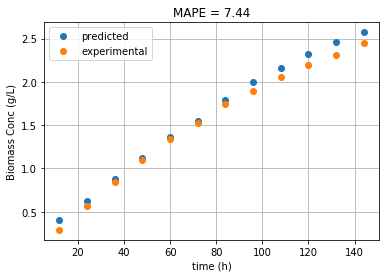

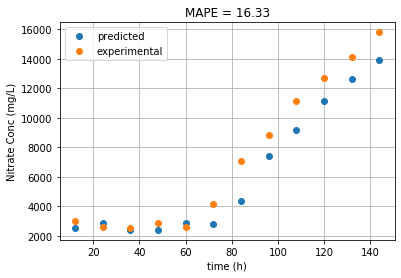

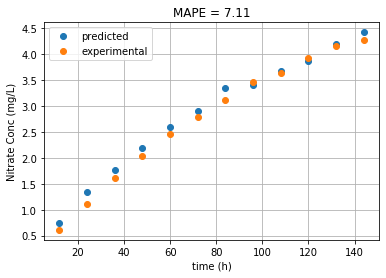

In [17]:
def MAPE(y_true, y_pred):
    MAPE_Total=0
    for i in range(len(y_pred)):
        MAPE = torch.abs((y_true[i:1+i,:]-y_pred[i:1+i,:])/y_true[i:1+i,:])
        MAPE_Total += (MAPE/len(y_pred))*100
    return MAPE_Total

import numpy as np
a = np.linspace(12,144,12)
v = torch.tensor(data3)
import matplotlib.pyplot as plt 
y1 = x_plot[:, 0:1] 
x1 = a
plt.plot(x1, y1,'o' ,label = "predicted") 

y2 = v[:, 0:1] 
x2 = a
plt.plot(x2, y2, 'o',label = "experimental") 
plt.xlabel('time (h)')
plt.ylabel('Biomass Conc (g/L)')
loss = MAPE(v[:, 0:1],x_plot[:, 0:1])
plt.title(('MAPE = {:.2f}'.format(loss.item())))
plt.grid(b=True,which='major', axis='both')
plt.legend()
plt.show() 


y1 = x_plot[:, 1:2] 
x1 = a
plt.plot(x1, y1,'o',label = "predicted") 

y2 = v[:, 1:2] 
x2 = a
plt.plot(x2, y2,'o',label = "experimental") 
plt.xlabel('time (h)')
plt.ylabel('Nitrate Conc (mg/L)')
loss = MAPE(v[:, 1:2],x_plot[:, 1:2])
plt.title(('MAPE = {:.2f}'.format(loss.item())))
plt.grid(b=True,which='major', axis='both')
plt.legend()
plt.show() 

y1 = x_plot[:, 2:3] 
x1 = a
plt.plot(x1, y1,'o',label = "predicted") 

y2 = v[:, 2:3] 
x2 = a
plt.plot(x2, y2,'o',label = "experimental") 
plt.xlabel('time (h)')
plt.ylabel('Nitrate Conc (mg/L)')
loss = MAPE(v[:, 2:3],x_plot[:, 2:3])
plt.title(('MAPE = {:.2f}'.format(loss.item())))
plt.grid(b=True,which='major', axis='both')
plt.legend()
plt.show() 


In [19]:
import pandas as pd
b=np.array(v)
c=np.array(x_plot)
book = xlrd.open_workbook('tested data.xlsx')
sheet = book.sheet_by_name('Sheet1')
writer = pd.ExcelWriter('tested data.xlsx', engine='xlsxwriter')
df1 = pd.DataFrame(b)
df1.to_excel(writer, header=True, index=True)
df2 = pd.DataFrame(c)
df2.to_excel(writer, startrow=13, header=True, index=True)
writer.save()